In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["grid.color"] = "w"
mpl.rcParams["axes.facecolor"] = "w"
mpl.rcParams["axes.edgecolor"] = "w"
mpl.rcParams["axes.titlecolor"] = "w"
mpl.rcParams["axes.labelcolor"] = "w"
mpl.rcParams["text.color"] = "w"
mpl.rcParams["xtick.color"] = "w"
mpl.rcParams["ytick.color"] = "w"

mpl.rcParams["axes.facecolor"] = "k"
mpl.rcParams["figure.facecolor"] = "k"
mpl.rcParams["figure.figsize"] = (8,6)
mpl.rcParams["axes.grid"] = False

In [2]:
import numpy as np
from tensorflow import keras

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + noise
    return series[..., np.newaxis].astype(np.float32)

The following comment might help better understand the implementation of `generate_time_series`:
- `freq1, freq2, offsets1, offsets2` are ndarrays of shape `(batch_size, 1)` with values $\in [0, 1]$
- `time` is an ndarray of shape `(n_steps,)` with first and last value being `0` and `1`
- Frequencies:
  - Frequency is what multiplies the time variable in a (periodic) function
  - `freq1 * 10 + 10` gives minimum frequency `10`, maximum frequency `20`
  - Similarly, `freq2 * 20 + 20` makes the overall frequency value varies uniformly in $[20, 40]$
- `time - offsets` is there to make the waves look different by shifting them
- The `- 0.5` in the noise part is to make the noise both positive and negative
- `np.newaxis` in the `return` is to make the return value an ndarray of shape `(batch_size, n_steps, 1)`
  - Note that this is because series is of shape `(batch_size, n_steps)`, which in turn because of `time - offsets` ([**Broadcasting**](https://numpy.org/doc/stable/user/basics.broadcasting.html))

In [4]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

A few words about broadcasting and the way Mr. Geron took `X_train, y_train`:
- Each `X` instance is `series[k, :n_steps]` for some `k`
- Each `y` instance is `series[k, -1]` (i.e. `series[k, n_steps]`) for some `k`
- To be able to do this, we must ensure that `series[k]` is generated by the same `offsets, freq` for all `k`

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "gx", markersize=10, mew=3)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

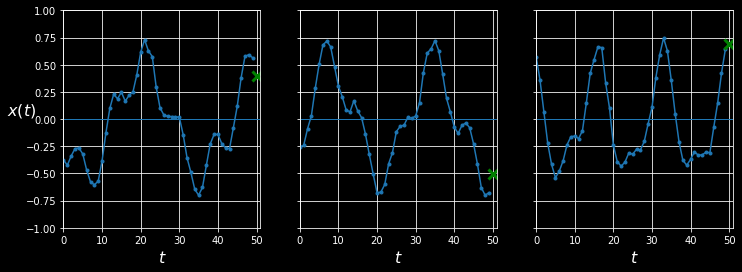

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    #plot_series(X_valid[col, :, 0], y=y_valid[col, 0],
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))

#plt.show()

## Baseline Metrics
- Naive forecasting: For each `X` instance, we will take its last value `X[-1]` as our prediction
- Linear regression: Just ordinary linear regression

In [7]:
y_pred = X_valid[:, -1]

**(?1)** Did you notice that in this part in the book the author took mean twice (`np.mean(keras.losses.mean_squared_error(y_valid, y_pred))`)? Why was that?<br>
**(R1)** See below.

In [8]:
keras.losses.mean_squared_error(y_valid, y_pred)

<tf.Tensor: shape=(2000,), dtype=float32, numpy=
array([0.02696938, 0.0300572 , 0.00259067, ..., 0.00443125, 0.00961478,
       0.04232119], dtype=float32)>

In [9]:
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

The `keras.losses.mean_squared_error()` is really quite crooked. Its mean part probably means that it will take the mean across the dimension of each instance, i.e across the feature values.

Or `keras.losses.mean_squared_error()` expects tensors of shape `(n,)`, but we feeded it `y_pred` and `y_valid` both of
shape `(2000, 1)`

In [10]:
keras.losses.mean_squared_error(np.squeeze(y_valid),
                                np.squeeze(y_pred)).numpy()

0.020211365

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
mean_squared_error(y_valid, y_pred)

0.020211367

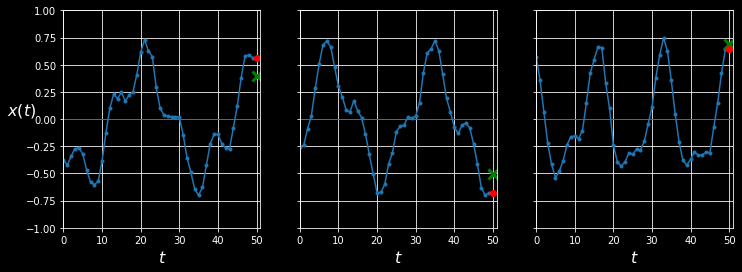

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y=y_valid[col, 0], y_pred=y_pred[col],
                y_label=("$x(t)$" if col==0 else None))

In [14]:
y_valid.shape, y_pred.shape

((2000, 1), (2000, 1))

### Linear regression using `sklearn`

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [17]:
np.squeeze(X_train, axis=-1).shape, np.squeeze(y_train, axis=-1).shape

((7000, 50), (7000,))

In [18]:
reg = LinearRegression()
reg.fit(np.squeeze(X_train, axis=-1), np.squeeze(y_train, axis=-1))

LinearRegression()

In [19]:
y_pred = reg.predict(np.squeeze(X_valid, axis=-1))

In [20]:
mean_squared_error(y_valid, y_pred)

0.0029311462

### Linear regression using `keras`

In [21]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1),
])

In [22]:
%%time
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=20, verbose=0)

CPU times: user 4.45 s, sys: 407 ms, total: 4.86 s
Wall time: 2.82 s


In [23]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0038


0.0038130288012325764

In [24]:
# double check our calculations.
y_pred = model.predict(X_valid)
y_pred.shape

(2000, 1)

In [25]:
mean_squared_error(y_valid, y_pred)

0.0038130293

## The simplest possible RNN

In [26]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=(None, 1)),
])

In [34]:
%%time
model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=20, verbose=0);

CPU times: user 1min 30s, sys: 6.93 s, total: 1min 37s
Wall time: 52.2 s


It seems that **RNN takes longer to train**.

In [31]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0123


0.01229865662753582

**(?)** The result of our experiment is worse than that in the book. Why is that? Just because the random seed?

In [35]:
import tensorflow as tf

In [36]:
%%time
np.random.seed(42)
tf.random.set_seed(42)

model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=20, verbose=0);

KeyboardInterrupt: 

In [32]:
%%time
np.random.seed(42)
tf.random.set_seed(42)

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(optimizer=optimizer, loss="mse")
model.fit(X_train, y_train, epochs=20, verbose=0);

CPU times: user 1min 19s, sys: 6.66 s, total: 1min 25s
Wall time: 44.7 s


In [33]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 4ms/step - loss: 0.0109


0.010912022553384304

## Todo
01. Try _exponential moving average_ in the **Baseline Metrics** part.